In [2]:
import tensorflow
print(tensorflow.__version__)

1.15.2


In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [3]:
!pip install adversarial-robustness-toolbox

     |████████████████████████████████| 1.1MB 15.8MB/s 
     |████████████████████████████████| 3.4MB 51.0MB/s 
     |████████████████████████████████| 25.3MB 123kB/s 
ERROR: kapre 0.3.5 has requirement tensorflow>=2.0.0, but you'll have tensorflow 1.15.2 which is incompatible.
  Found existing installation: llvmlite 0.34.0
    Uninstalling llvmlite-0.34.0:
      Successfully uninstalled llvmlite-0.34.0
  Found existing installation: numba 0.51.2
    Uninstalling numba-0.51.2:
      Successfully uninstalled numba-0.51.2


In [4]:
import art

In [5]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Flatten, InputLayer, Reshape

from art.classifiers import KerasClassifier

if tf.executing_eagerly():
    tf.python.framework.ops.disable_eager_execution()

Using TensorFlow backend.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: The module art.classifiers will be removed in ART 1.8.0 and replaced with art.estimators.classification
  # This is added back by InteractiveShellApp.init_path()


In [6]:
import art
from art.utils import load_mnist

# Load the dataset, and split the test data into test and steal datasets.
(x_train, y_train), (x_test0, y_test0), _, _ = load_mnist()
len_steal = 5000
indices = np.random.permutation(len(x_test0))
x_steal = x_test0[indices[:len_steal]]
y_steal = y_test0[indices[:len_steal]]
x_test = x_test0[indices[len_steal:]]
y_test = y_test0[indices[len_steal:]]

im_shape = x_train[0].shape
def get_model(num_classes=10, c1=32, c2=64, d1=128):
    model = Sequential()
    model.add(Conv2D(c1, kernel_size=(3, 3), activation='relu', input_shape=im_shape))
    model.add(Conv2D(c2, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(d1, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss=keras.losses.categorical_crossentropy, optimizer="sgd",
                          metrics=['accuracy'])
    return model

In [7]:
# Train the original model.
num_epochs = 5
model = get_model(num_classes=10, c1=32, c2=64, d1=128)
print("Original model training:")
model.fit(x_train, y_train, batch_size=100, epochs=num_epochs)
print("Original model evaluation:")
print(model.evaluate(x_test, y_test))
classifier_original = KerasClassifier(model, clip_values=(0, 1), use_logits=False)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.



/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/tensor_util.py:521: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  tensor_proto.tensor_content = nparray.tostring()
/tensorflow-1.15.2/python3.7/keras/engine/training_utils.py:811: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  if isinstance(loss, collections.Mapping):
/tensorflow-1.15.2/python3.7/keras/engine/training_utils.py:823: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  elif isinstance(loss, collections.Sequence):
/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/tensor_util.py:521: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  tensor_proto.tensor_content = nparray.tostring()


Original model training:

Epoch 1/5
60000/60000 [==============================] - 104s 2ms/step - loss: 0.6920 - accuracy: 0.8150
Epoch 2/5
60000/60000 [==============================] - 103s 2ms/step - loss: 0.2369 - accuracy: 0.9293
Epoch 3/5
60000/60000 [==============================] - 103s 2ms/step - loss: 0.1790 - accuracy: 0.9466
Epoch 4/5
60000/60000 [==============================] - 103s 2ms/step - loss: 0.1450 - accuracy: 0.9563
Epoch 5/5
60000/60000 [==============================] - 103s 2ms/step - loss: 0.1247 - accuracy: 0.9626
Original model evaluation:
5000/5000 [==============================] - 2s 496us/step
[0.1294230823457241, 0.9598000049591064]


In [8]:
# Stealing from the unprotected classifier.
from art.attacks import ExtractionAttack
from art.attacks.extraction import CopycatCNN, KnockoffNets

attack_catalogue = {"Probabilistic CopycatCNN": CopycatCNN(classifier=classifier_original,
                                              batch_size_fit=64,
                                              batch_size_query=64,
                                              nb_epochs=num_epochs,
                                              nb_stolen=len_steal,
                                              use_probability=True),
                    "Argmax CopycatCNN": CopycatCNN(classifier=classifier_original,
                                              batch_size_fit=64,
                                              batch_size_query=64,
                                              nb_epochs=num_epochs,
                                              nb_stolen=len_steal,
                                              use_probability=False),
                    "Probabilistic KnockoffNets": KnockoffNets(classifier=classifier_original,
                                              batch_size_fit=64,
                                              batch_size_query=64,
                                              nb_epochs=num_epochs,
                                              nb_stolen=len_steal,
                                              use_probability=True),
                    "Argmax KnockoffNets": KnockoffNets(classifier=classifier_original,
                                              batch_size_fit=64,
                                              batch_size_query=64,
                                              nb_epochs=num_epochs,
                                              nb_stolen=len_steal,
                                              use_probability=False),
                   }

results = []
for len_steal in [250, 500, 1000, 2000, 4000, 5000]:
    indices = np.random.permutation(len(x_test0))
    x_steal = x_test0[indices[:len_steal]]
    y_steal = y_test0[indices[:len_steal]]
    x_test = x_test0[indices[len_steal:]]
    y_test = y_test0[indices[len_steal:]]

    for name, attack in attack_catalogue.items():
        model_stolen = get_model(num_classes=10, c1=32, c2=64, d1=128)
        classifier_stolen = KerasClassifier(model_stolen, clip_values=(0, 1), use_logits=False)
        classifier_stolen = attack.extract(x_steal, y_steal, thieved_classifier=classifier_stolen)
        acc = classifier_stolen._model.evaluate(x_test, y_test)[1]
        print(name, ":", acc)
        results.append((name, len_steal, acc))

/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/tensor_util.py:521: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  tensor_proto.tensor_content = nparray.tostring()
/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/tensor_util.py:521: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  tensor_proto.tensor_content = nparray.tostring()


Epoch 1/5
3/3 [==============================] - 0s 131ms/step - loss: 2.2901 - accuracy: 0.1510
Epoch 2/5
3/3 [==============================] - 0s 109ms/step - loss: 2.2753 - accuracy: 0.2500
Epoch 3/5
3/3 [==============================] - 0s 112ms/step - loss: 2.2567 - accuracy: 0.3385
Epoch 4/5
3/3 [==============================] - 0s 116ms/step - loss: 2.2456 - accuracy: 0.3281
Epoch 5/5
9750/9750 [==============================] - 5s 491us/step
Probabilistic CopycatCNN : 0.3713846206665039


/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/tensor_util.py:521: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  tensor_proto.tensor_content = nparray.tostring()


Epoch 1/5
3/3 [==============================] - 0s 132ms/step - loss: 2.3103 - accuracy: 0.1458
Epoch 2/5
3/3 [==============================] - 0s 114ms/step - loss: 2.3052 - accuracy: 0.1354
Epoch 3/5
3/3 [==============================] - 0s 109ms/step - loss: 2.2712 - accuracy: 0.2240
Epoch 4/5
3/3 [==============================] - 0s 115ms/step - loss: 2.2496 - accuracy: 0.2604
Epoch 5/5
9750/9750 [==============================] - 5s 488us/step
Argmax CopycatCNN : 0.26923078298568726


/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/tensor_util.py:521: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  tensor_proto.tensor_content = nparray.tostring()


9750/9750 [==============================] - 5s 491us/step
Probabilistic KnockoffNets : 0.3036923110485077


/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/tensor_util.py:521: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  tensor_proto.tensor_content = nparray.tostring()


9750/9750 [==============================] - 5s 494us/step
Argmax KnockoffNets : 0.2924102544784546


/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/tensor_util.py:521: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  tensor_proto.tensor_content = nparray.tostring()


Epoch 1/5
7/7 [==============================] - 1s 133ms/step - loss: 2.2993 - accuracy: 0.1406
Epoch 2/5
7/7 [==============================] - 1s 116ms/step - loss: 2.2716 - accuracy: 0.3058
Epoch 3/5
7/7 [==============================] - 1s 115ms/step - loss: 2.2467 - accuracy: 0.3594
Epoch 4/5
7/7 [==============================] - 1s 114ms/step - loss: 2.2132 - accuracy: 0.3973
Epoch 5/5
9500/9500 [==============================] - 5s 497us/step
Probabilistic CopycatCNN : 0.3573684096336365


/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/tensor_util.py:521: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  tensor_proto.tensor_content = nparray.tostring()


Epoch 1/5
7/7 [==============================] - 1s 129ms/step - loss: 2.2946 - accuracy: 0.0759
Epoch 2/5
7/7 [==============================] - 1s 115ms/step - loss: 2.2885 - accuracy: 0.1161
Epoch 3/5
7/7 [==============================] - 1s 118ms/step - loss: 2.2743 - accuracy: 0.1964
Epoch 4/5
7/7 [==============================] - 1s 118ms/step - loss: 2.2629 - accuracy: 0.2612
Epoch 5/5
9500/9500 [==============================] - 5s 496us/step
Argmax CopycatCNN : 0.30505263805389404


/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/tensor_util.py:521: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  tensor_proto.tensor_content = nparray.tostring()


9500/9500 [==============================] - 5s 509us/step
Probabilistic KnockoffNets : 0.3692631721496582


/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/tensor_util.py:521: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  tensor_proto.tensor_content = nparray.tostring()


9500/9500 [==============================] - 5s 507us/step
Argmax KnockoffNets : 0.3014736771583557


/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/tensor_util.py:521: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  tensor_proto.tensor_content = nparray.tostring()


Epoch 1/5
15/15 [==============================] - 2s 125ms/step - loss: 2.2840 - accuracy: 0.1969
Epoch 2/5
15/15 [==============================] - 2s 116ms/step - loss: 2.2461 - accuracy: 0.3406
Epoch 3/5
15/15 [==============================] - 2s 113ms/step - loss: 2.2032 - accuracy: 0.4469
Epoch 4/5
15/15 [==============================] - 2s 114ms/step - loss: 2.1255 - accuracy: 0.5667
Epoch 5/5
9000/9000 [==============================] - 5s 519us/step
Probabilistic CopycatCNN : 0.5964444279670715


/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/tensor_util.py:521: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  tensor_proto.tensor_content = nparray.tostring()


Epoch 1/5
15/15 [==============================] - 2s 125ms/step - loss: 2.2818 - accuracy: 0.1344
Epoch 2/5
15/15 [==============================] - 2s 116ms/step - loss: 2.2212 - accuracy: 0.2708
Epoch 3/5
15/15 [==============================] - 2s 115ms/step - loss: 2.1381 - accuracy: 0.3646
Epoch 4/5
15/15 [==============================] - 2s 115ms/step - loss: 1.9966 - accuracy: 0.5250
Epoch 5/5
9000/9000 [==============================] - 5s 516us/step
Argmax CopycatCNN : 0.7044444680213928


/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/tensor_util.py:521: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  tensor_proto.tensor_content = nparray.tostring()


9000/9000 [==============================] - 5s 512us/step
Probabilistic KnockoffNets : 0.7868888974189758


/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/tensor_util.py:521: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  tensor_proto.tensor_content = nparray.tostring()


9000/9000 [==============================] - 5s 514us/step
Argmax KnockoffNets : 0.6166666746139526


/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/tensor_util.py:521: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  tensor_proto.tensor_content = nparray.tostring()


Epoch 1/5
31/31 [==============================] - 4s 121ms/step - loss: 2.2522 - accuracy: 0.3059
Epoch 2/5
31/31 [==============================] - 4s 114ms/step - loss: 2.0838 - accuracy: 0.5590
Epoch 3/5
31/31 [==============================] - 4s 115ms/step - loss: 1.5247 - accuracy: 0.7208
Epoch 4/5
31/31 [==============================] - 4s 115ms/step - loss: 0.8220 - accuracy: 0.8165
Epoch 5/5
8000/8000 [==============================] - 4s 521us/step
Probabilistic CopycatCNN : 0.8376250267028809


/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/tensor_util.py:521: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  tensor_proto.tensor_content = nparray.tostring()


Epoch 1/5
31/31 [==============================] - 4s 119ms/step - loss: 2.2477 - accuracy: 0.1860
Epoch 2/5
31/31 [==============================] - 4s 115ms/step - loss: 2.0965 - accuracy: 0.5227
Epoch 3/5
31/31 [==============================] - 4s 115ms/step - loss: 1.6505 - accuracy: 0.6608
Epoch 4/5
31/31 [==============================] - 4s 117ms/step - loss: 0.9424 - accuracy: 0.7767
Epoch 5/5
8000/8000 [==============================] - 4s 528us/step
Argmax CopycatCNN : 0.7897499799728394


/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/tensor_util.py:521: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  tensor_proto.tensor_content = nparray.tostring()


8000/8000 [==============================] - 4s 528us/step
Probabilistic KnockoffNets : 0.8318750262260437


/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/tensor_util.py:521: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  tensor_proto.tensor_content = nparray.tostring()


8000/8000 [==============================] - 4s 535us/step
Argmax KnockoffNets : 0.8631250262260437


/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/tensor_util.py:521: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  tensor_proto.tensor_content = nparray.tostring()


Epoch 1/5
62/62 [==============================] - 7s 118ms/step - loss: 2.1605 - accuracy: 0.3954
Epoch 2/5
62/62 [==============================] - 7s 115ms/step - loss: 1.1403 - accuracy: 0.7639
Epoch 3/5
62/62 [==============================] - 7s 114ms/step - loss: 0.4816 - accuracy: 0.8785
Epoch 4/5
62/62 [==============================] - 7s 112ms/step - loss: 0.3994 - accuracy: 0.8866
Epoch 5/5
6000/6000 [==============================] - 3s 524us/step
Probabilistic CopycatCNN : 0.8921666741371155


/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/tensor_util.py:521: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  tensor_proto.tensor_content = nparray.tostring()


Epoch 1/5
62/62 [==============================] - 7s 116ms/step - loss: 2.2489 - accuracy: 0.3125
Epoch 2/5
62/62 [==============================] - 7s 115ms/step - loss: 1.7586 - accuracy: 0.6918
Epoch 3/5
62/62 [==============================] - 7s 114ms/step - loss: 0.6238 - accuracy: 0.8443
Epoch 4/5
62/62 [==============================] - 7s 114ms/step - loss: 0.3699 - accuracy: 0.8853
Epoch 5/5
6000/6000 [==============================] - 3s 545us/step
Argmax CopycatCNN : 0.8924999833106995


/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/tensor_util.py:521: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  tensor_proto.tensor_content = nparray.tostring()


6000/6000 [==============================] - 3s 547us/step
Probabilistic KnockoffNets : 0.8981666564941406


/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/tensor_util.py:521: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  tensor_proto.tensor_content = nparray.tostring()


6000/6000 [==============================] - 3s 551us/step
Argmax KnockoffNets : 0.8794999718666077


/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/tensor_util.py:521: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  tensor_proto.tensor_content = nparray.tostring()


Epoch 1/5
78/78 [==============================] - 9s 116ms/step - loss: 2.0237 - accuracy: 0.5270
Epoch 2/5
78/78 [==============================] - 9s 114ms/step - loss: 0.7101 - accuracy: 0.8339
Epoch 3/5
78/78 [==============================] - 9s 113ms/step - loss: 0.4002 - accuracy: 0.8910
Epoch 4/5
78/78 [==============================] - 9s 113ms/step - loss: 0.3392 - accuracy: 0.9149
Epoch 5/5
5000/5000 [==============================] - 3s 545us/step
Probabilistic CopycatCNN : 0.9002000093460083


/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/tensor_util.py:521: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  tensor_proto.tensor_content = nparray.tostring()


Epoch 1/5
78/78 [==============================] - 9s 118ms/step - loss: 2.1271 - accuracy: 0.3758
Epoch 2/5
78/78 [==============================] - 9s 115ms/step - loss: 0.9381 - accuracy: 0.7774
Epoch 3/5
78/78 [==============================] - 9s 115ms/step - loss: 0.3694 - accuracy: 0.8936
Epoch 4/5
78/78 [==============================] - 9s 115ms/step - loss: 0.2737 - accuracy: 0.9137
Epoch 5/5
5000/5000 [==============================] - 3s 563us/step
Argmax CopycatCNN : 0.90420001745224


/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/tensor_util.py:521: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  tensor_proto.tensor_content = nparray.tostring()


5000/5000 [==============================] - 3s 562us/step
Probabilistic KnockoffNets : 0.9052000045776367


/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/tensor_util.py:521: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  tensor_proto.tensor_content = nparray.tostring()


5000/5000 [==============================] - 3s 552us/step
Argmax KnockoffNets : 0.894599974155426


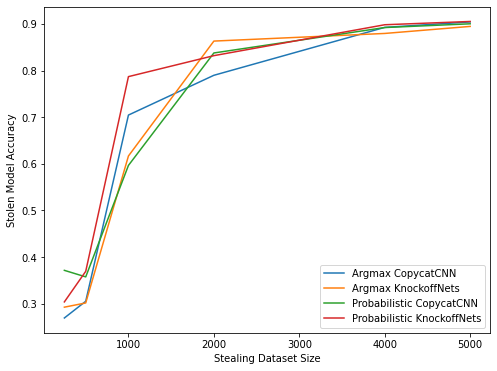

In [9]:
import pandas as pd
df = pd.DataFrame(results, columns=('Method Name', 'Stealing Dataset Size', 'Accuracy'))
fig, ax = plt.subplots(figsize=(8,6))
ax.set_xlabel("Stealing Dataset Size")
ax.set_ylabel("Stolen Model Accuracy")
for name, group in df.groupby("Method Name"):
    group.plot(1, 2, ax=ax, label=name)
plt.show()

In [10]:
from art.defences.postprocessor import ReverseSigmoid
postprocessor = ReverseSigmoid(beta=1.0, gamma=0.2)
classifier_protected = KerasClassifier(model, clip_values=(0, 1), use_logits=False, postprocessing_defences=postprocessor)

# Below is used by `FunctionallyEquivalentExtraction`.
model_flat = Sequential([InputLayer([784]), Reshape([28, 28, 1]), model])
model_flat.compile('sgd', 'categorical_crossentropy', ['accuracy'])
classifier_flat_protected = KerasClassifier(model_flat, clip_values=(0, 1), use_logits=False, postprocessing_defences=postprocessor)

In [11]:
attack_catalogue = {
                    "Probabilistic CopycatCNN (vs. Protected)": CopycatCNN(classifier=classifier_protected,
                                              batch_size_fit=64,
                                              batch_size_query=64,
                                              nb_epochs=num_epochs,
                                              nb_stolen=len_steal,
                                              use_probability=True),
                    "Argmax CopycatCNN (vs. Protected)": CopycatCNN(classifier=classifier_protected,
                                              batch_size_fit=64,
                                              batch_size_query=64,
                                              nb_epochs=num_epochs,
                                              nb_stolen=len_steal,
                                              use_probability=False),
                    "Probabilistic KnockoffNets (vs. Protected)": KnockoffNets(classifier=classifier_protected,
                                              batch_size_fit=64,
                                              batch_size_query=64,
                                              nb_epochs=num_epochs,
                                              nb_stolen=len_steal,
                                              use_probability=True),
                    "Argmax KnockoffNets (vs. Protected)": KnockoffNets(classifier=classifier_protected,
                                              batch_size_fit=64,
                                              batch_size_query=64,
                                              nb_epochs=num_epochs,
                                              nb_stolen=len_steal,
                                              use_probability=False),
#                     "FunctionallyEquivalentExtraction": FunctionallyEquivalentExtraction(classifier=classifier_flat_protected,
#                                               num_neurons=128),  # This one takes too long time for this dataset/model.
                    }

results_protected = []
for len_steal in [250, 500, 1000, 2000, 4000, 5000]:
    indices = np.random.permutation(len(x_test0))
    x_steal = x_test0[indices[:len_steal]]
    y_steal = y_test0[indices[:len_steal]]
    x_test = x_test0[indices[len_steal:]]
    y_test = y_test0[indices[len_steal:]]

    for name, attack in attack_catalogue.items():
        model_stolen = get_model(num_classes=10, c1=32, c2=64, d1=128)
        classifier_stolen = KerasClassifier(model_stolen, clip_values=(0, 1), use_logits=False)
        if name=="FunctionallyEquivalentExtraction":
            classifier_stolen = attack.extract(np.reshape(x_steal, [len(x_steal), -1]), y_steal, thieved_classifier=classifier_stolen)
        else:
            classifier_stolen = attack.extract(x_steal, y_steal, thieved_classifier=classifier_stolen)
        
        acc = classifier_stolen._model.evaluate(x_test, y_test)[1]
        print(name, ":", acc)
        results_protected.append((name, len_steal, acc))

/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/tensor_util.py:521: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  tensor_proto.tensor_content = nparray.tostring()
/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/tensor_util.py:521: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  tensor_proto.tensor_content = nparray.tostring()


Epoch 1/5
3/3 [==============================] - 1s 198ms/step - loss: 2.3031 - accuracy: 0.2031
Epoch 2/5
3/3 [==============================] - 0s 112ms/step - loss: 2.3038 - accuracy: 0.2552
Epoch 3/5
3/3 [==============================] - 0s 112ms/step - loss: 2.3039 - accuracy: 0.1562
Epoch 4/5
3/3 [==============================] - 0s 113ms/step - loss: 2.3033 - accuracy: 0.2083
Epoch 5/5
9750/9750 [==============================] - 5s 536us/step
Probabilistic CopycatCNN (vs. Protected) : 0.18974359333515167


/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/tensor_util.py:521: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  tensor_proto.tensor_content = nparray.tostring()


Epoch 1/5
3/3 [==============================] - 1s 190ms/step - loss: 2.2854 - accuracy: 0.1458
Epoch 2/5
3/3 [==============================] - 0s 119ms/step - loss: 2.2602 - accuracy: 0.1667
Epoch 3/5
3/3 [==============================] - 0s 113ms/step - loss: 2.2361 - accuracy: 0.1719
Epoch 4/5
3/3 [==============================] - 0s 113ms/step - loss: 2.2245 - accuracy: 0.2240
Epoch 5/5
9750/9750 [==============================] - 5s 531us/step
Argmax CopycatCNN (vs. Protected) : 0.2155897468328476


/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/tensor_util.py:521: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  tensor_proto.tensor_content = nparray.tostring()


9750/9750 [==============================] - 5s 554us/step
Probabilistic KnockoffNets (vs. Protected) : 0.10164102911949158


/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/tensor_util.py:521: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  tensor_proto.tensor_content = nparray.tostring()


9750/9750 [==============================] - 5s 556us/step
Argmax KnockoffNets (vs. Protected) : 0.2434871792793274


/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/tensor_util.py:521: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  tensor_proto.tensor_content = nparray.tostring()


Epoch 1/5
7/7 [==============================] - 1s 156ms/step - loss: 2.3051 - accuracy: 0.1652
Epoch 2/5
7/7 [==============================] - 1s 113ms/step - loss: 2.3040 - accuracy: 0.1808
Epoch 3/5
7/7 [==============================] - 1s 114ms/step - loss: 2.3042 - accuracy: 0.1518
Epoch 4/5
7/7 [==============================] - 1s 116ms/step - loss: 2.3036 - accuracy: 0.1674
Epoch 5/5
9500/9500 [==============================] - 5s 546us/step
Probabilistic CopycatCNN (vs. Protected) : 0.1749473661184311


/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/tensor_util.py:521: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  tensor_proto.tensor_content = nparray.tostring()


Epoch 1/5
7/7 [==============================] - 1s 161ms/step - loss: 2.2881 - accuracy: 0.1629
Epoch 2/5
7/7 [==============================] - 1s 117ms/step - loss: 2.2750 - accuracy: 0.1741
Epoch 3/5
7/7 [==============================] - 1s 114ms/step - loss: 2.2601 - accuracy: 0.2411
Epoch 4/5
7/7 [==============================] - 1s 115ms/step - loss: 2.2351 - accuracy: 0.2857
Epoch 5/5
9500/9500 [==============================] - 5s 559us/step
Argmax CopycatCNN (vs. Protected) : 0.41252630949020386


/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/tensor_util.py:521: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  tensor_proto.tensor_content = nparray.tostring()


9500/9500 [==============================] - 5s 554us/step
Probabilistic KnockoffNets (vs. Protected) : 0.13526315987110138


/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/tensor_util.py:521: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  tensor_proto.tensor_content = nparray.tostring()


9500/9500 [==============================] - 5s 563us/step
Argmax KnockoffNets (vs. Protected) : 0.27399998903274536


/usr/local/lib/python3.7/dist-packages/art/defences/postprocessor/reverse_sigmoid.py:75: RuntimeWarning: divide by zero encountered in log
  perturbation_r = self.beta * (sigmoid(-self.gamma * np.log((1.0 - preds_clipped) / preds_clipped)) - 0.5)
/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/tensor_util.py:521: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  tensor_proto.tensor_content = nparray.tostring()


Epoch 1/5
15/15 [==============================] - 2s 137ms/step - loss: 2.3034 - accuracy: 0.1167
Epoch 2/5
15/15 [==============================] - 2s 115ms/step - loss: 2.3028 - accuracy: 0.1292
Epoch 3/5
15/15 [==============================] - 2s 115ms/step - loss: 2.3024 - accuracy: 0.1208
Epoch 4/5
15/15 [==============================] - 2s 114ms/step - loss: 2.3024 - accuracy: 0.1250
Epoch 5/5
9000/9000 [==============================] - 5s 556us/step
Probabilistic CopycatCNN (vs. Protected) : 0.13699999451637268


/usr/local/lib/python3.7/dist-packages/art/defences/postprocessor/reverse_sigmoid.py:75: RuntimeWarning: divide by zero encountered in log
  perturbation_r = self.beta * (sigmoid(-self.gamma * np.log((1.0 - preds_clipped) / preds_clipped)) - 0.5)
/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/tensor_util.py:521: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  tensor_proto.tensor_content = nparray.tostring()


Epoch 1/5
15/15 [==============================] - 2s 135ms/step - loss: 2.2812 - accuracy: 0.1677
Epoch 2/5
15/15 [==============================] - 2s 114ms/step - loss: 2.2450 - accuracy: 0.2990
Epoch 3/5
15/15 [==============================] - 2s 115ms/step - loss: 2.1912 - accuracy: 0.4000
Epoch 4/5
15/15 [==============================] - 2s 115ms/step - loss: 2.1039 - accuracy: 0.4781
Epoch 5/5
9000/9000 [==============================] - 5s 568us/step
Argmax CopycatCNN (vs. Protected) : 0.5131111145019531


/usr/local/lib/python3.7/dist-packages/art/defences/postprocessor/reverse_sigmoid.py:75: RuntimeWarning: divide by zero encountered in log
  perturbation_r = self.beta * (sigmoid(-self.gamma * np.log((1.0 - preds_clipped) / preds_clipped)) - 0.5)
/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/tensor_util.py:521: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  tensor_proto.tensor_content = nparray.tostring()


9000/9000 [==============================] - 5s 560us/step
Probabilistic KnockoffNets (vs. Protected) : 0.14488889276981354


/usr/local/lib/python3.7/dist-packages/art/defences/postprocessor/reverse_sigmoid.py:75: RuntimeWarning: divide by zero encountered in log
  perturbation_r = self.beta * (sigmoid(-self.gamma * np.log((1.0 - preds_clipped) / preds_clipped)) - 0.5)
/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/tensor_util.py:521: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  tensor_proto.tensor_content = nparray.tostring()


9000/9000 [==============================] - 5s 579us/step
Argmax KnockoffNets (vs. Protected) : 0.6983333230018616


/usr/local/lib/python3.7/dist-packages/art/defences/postprocessor/reverse_sigmoid.py:75: RuntimeWarning: divide by zero encountered in log
  perturbation_r = self.beta * (sigmoid(-self.gamma * np.log((1.0 - preds_clipped) / preds_clipped)) - 0.5)
/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/tensor_util.py:521: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  tensor_proto.tensor_content = nparray.tostring()


Epoch 1/5
31/31 [==============================] - 4s 127ms/step - loss: 2.3033 - accuracy: 0.1472
Epoch 2/5
31/31 [==============================] - 4s 115ms/step - loss: 2.3028 - accuracy: 0.1532
Epoch 3/5
31/31 [==============================] - 4s 115ms/step - loss: 2.3023 - accuracy: 0.1855
Epoch 4/5
31/31 [==============================] - 4s 115ms/step - loss: 2.3018 - accuracy: 0.2213
Epoch 5/5
8000/8000 [==============================] - 5s 569us/step
Probabilistic CopycatCNN (vs. Protected) : 0.234375


/usr/local/lib/python3.7/dist-packages/art/defences/postprocessor/reverse_sigmoid.py:75: RuntimeWarning: divide by zero encountered in log
  perturbation_r = self.beta * (sigmoid(-self.gamma * np.log((1.0 - preds_clipped) / preds_clipped)) - 0.5)
/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/tensor_util.py:521: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  tensor_proto.tensor_content = nparray.tostring()


Epoch 1/5
31/31 [==============================] - 4s 125ms/step - loss: 2.2721 - accuracy: 0.1658
Epoch 2/5
31/31 [==============================] - 4s 114ms/step - loss: 2.1720 - accuracy: 0.4062
Epoch 3/5
31/31 [==============================] - 4s 114ms/step - loss: 1.8695 - accuracy: 0.6003
Epoch 4/5
31/31 [==============================] - 4s 114ms/step - loss: 1.1392 - accuracy: 0.7727
Epoch 5/5
8000/8000 [==============================] - 5s 578us/step
Argmax CopycatCNN (vs. Protected) : 0.856374979019165


/usr/local/lib/python3.7/dist-packages/art/defences/postprocessor/reverse_sigmoid.py:75: RuntimeWarning: divide by zero encountered in log
  perturbation_r = self.beta * (sigmoid(-self.gamma * np.log((1.0 - preds_clipped) / preds_clipped)) - 0.5)
/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/tensor_util.py:521: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  tensor_proto.tensor_content = nparray.tostring()


8000/8000 [==============================] - 5s 594us/step
Probabilistic KnockoffNets (vs. Protected) : 0.2122499942779541


/usr/local/lib/python3.7/dist-packages/art/defences/postprocessor/reverse_sigmoid.py:75: RuntimeWarning: divide by zero encountered in log
  perturbation_r = self.beta * (sigmoid(-self.gamma * np.log((1.0 - preds_clipped) / preds_clipped)) - 0.5)
/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/tensor_util.py:521: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  tensor_proto.tensor_content = nparray.tostring()


8000/8000 [==============================] - 5s 584us/step
Argmax KnockoffNets (vs. Protected) : 0.8546249866485596


/usr/local/lib/python3.7/dist-packages/art/defences/postprocessor/reverse_sigmoid.py:75: RuntimeWarning: divide by zero encountered in log
  perturbation_r = self.beta * (sigmoid(-self.gamma * np.log((1.0 - preds_clipped) / preds_clipped)) - 0.5)
/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/tensor_util.py:521: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  tensor_proto.tensor_content = nparray.tostring()


Epoch 1/5
62/62 [==============================] - 8s 122ms/step - loss: 2.3031 - accuracy: 0.0572
Epoch 2/5
62/62 [==============================] - 7s 115ms/step - loss: 2.3022 - accuracy: 0.1099
Epoch 3/5
62/62 [==============================] - 7s 115ms/step - loss: 2.3016 - accuracy: 0.1565
Epoch 4/5
62/62 [==============================] - 7s 114ms/step - loss: 2.3010 - accuracy: 0.2301
Epoch 5/5
6000/6000 [==============================] - 4s 596us/step
Probabilistic CopycatCNN (vs. Protected) : 0.29750001430511475


/usr/local/lib/python3.7/dist-packages/art/defences/postprocessor/reverse_sigmoid.py:75: RuntimeWarning: divide by zero encountered in log
  perturbation_r = self.beta * (sigmoid(-self.gamma * np.log((1.0 - preds_clipped) / preds_clipped)) - 0.5)
/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/tensor_util.py:521: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  tensor_proto.tensor_content = nparray.tostring()


Epoch 1/5
62/62 [==============================] - 8s 122ms/step - loss: 2.2309 - accuracy: 0.2765
Epoch 2/5
62/62 [==============================] - 7s 115ms/step - loss: 1.6646 - accuracy: 0.6830
Epoch 3/5
62/62 [==============================] - 7s 114ms/step - loss: 0.6093 - accuracy: 0.8385
Epoch 4/5
62/62 [==============================] - 7s 113ms/step - loss: 0.3852 - accuracy: 0.8944
Epoch 5/5
6000/6000 [==============================] - 4s 587us/step
Argmax CopycatCNN (vs. Protected) : 0.8763333559036255


/usr/local/lib/python3.7/dist-packages/art/defences/postprocessor/reverse_sigmoid.py:75: RuntimeWarning: divide by zero encountered in log
  perturbation_r = self.beta * (sigmoid(-self.gamma * np.log((1.0 - preds_clipped) / preds_clipped)) - 0.5)
/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/tensor_util.py:521: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  tensor_proto.tensor_content = nparray.tostring()


6000/6000 [==============================] - 4s 593us/step
Probabilistic KnockoffNets (vs. Protected) : 0.26600000262260437


/usr/local/lib/python3.7/dist-packages/art/defences/postprocessor/reverse_sigmoid.py:75: RuntimeWarning: divide by zero encountered in log
  perturbation_r = self.beta * (sigmoid(-self.gamma * np.log((1.0 - preds_clipped) / preds_clipped)) - 0.5)
/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/tensor_util.py:521: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  tensor_proto.tensor_content = nparray.tostring()


6000/6000 [==============================] - 4s 606us/step
Argmax KnockoffNets (vs. Protected) : 0.8901666402816772


/usr/local/lib/python3.7/dist-packages/art/defences/postprocessor/reverse_sigmoid.py:75: RuntimeWarning: divide by zero encountered in log
  perturbation_r = self.beta * (sigmoid(-self.gamma * np.log((1.0 - preds_clipped) / preds_clipped)) - 0.5)
/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/tensor_util.py:521: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  tensor_proto.tensor_content = nparray.tostring()


Epoch 1/5
78/78 [==============================] - 9s 119ms/step - loss: 2.3029 - accuracy: 0.1352
Epoch 2/5
78/78 [==============================] - 9s 113ms/step - loss: 2.3021 - accuracy: 0.1484
Epoch 3/5
78/78 [==============================] - 9s 113ms/step - loss: 2.3016 - accuracy: 0.2109
Epoch 4/5
78/78 [==============================] - 9s 113ms/step - loss: 2.3012 - accuracy: 0.2819
Epoch 5/5
5000/5000 [==============================] - 3s 624us/step
Probabilistic CopycatCNN (vs. Protected) : 0.33660000562667847


/usr/local/lib/python3.7/dist-packages/art/defences/postprocessor/reverse_sigmoid.py:75: RuntimeWarning: divide by zero encountered in log
  perturbation_r = self.beta * (sigmoid(-self.gamma * np.log((1.0 - preds_clipped) / preds_clipped)) - 0.5)
/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/tensor_util.py:521: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  tensor_proto.tensor_content = nparray.tostring()


Epoch 1/5
78/78 [==============================] - 9s 119ms/step - loss: 2.1580 - accuracy: 0.4195
Epoch 2/5
78/78 [==============================] - 9s 113ms/step - loss: 1.0407 - accuracy: 0.7666
Epoch 3/5
78/78 [==============================] - 9s 113ms/step - loss: 0.4330 - accuracy: 0.8756
Epoch 4/5
78/78 [==============================] - 9s 113ms/step - loss: 0.3230 - accuracy: 0.9087
Epoch 5/5
5000/5000 [==============================] - 3s 628us/step
Argmax CopycatCNN (vs. Protected) : 0.9010000228881836


/usr/local/lib/python3.7/dist-packages/art/defences/postprocessor/reverse_sigmoid.py:75: RuntimeWarning: divide by zero encountered in log
  perturbation_r = self.beta * (sigmoid(-self.gamma * np.log((1.0 - preds_clipped) / preds_clipped)) - 0.5)
/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/tensor_util.py:521: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  tensor_proto.tensor_content = nparray.tostring()


5000/5000 [==============================] - 3s 603us/step
Probabilistic KnockoffNets (vs. Protected) : 0.3418000042438507


/usr/local/lib/python3.7/dist-packages/art/defences/postprocessor/reverse_sigmoid.py:75: RuntimeWarning: divide by zero encountered in log
  perturbation_r = self.beta * (sigmoid(-self.gamma * np.log((1.0 - preds_clipped) / preds_clipped)) - 0.5)
/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/tensor_util.py:521: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  tensor_proto.tensor_content = nparray.tostring()


5000/5000 [==============================] - 3s 639us/step
Argmax KnockoffNets (vs. Protected) : 0.8931999802589417


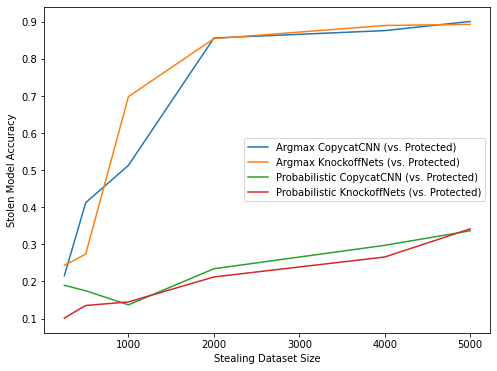

In [12]:
import pandas as pd
df_protected = pd.DataFrame(results_protected, columns=('Method Name', 'Stealing Dataset Size', 'Accuracy'))
fig, ax = plt.subplots(figsize=(8,6))
ax.set_xlabel("Stealing Dataset Size")
ax.set_ylabel("Stolen Model Accuracy")
for name, group in df_protected.groupby("Method Name"):
    group.plot(1, 2, ax=ax, label=name)
plt.show()

In [13]:
df_combined = pd.concat([df, df_protected])
groupby = df_combined.groupby("Method Name")

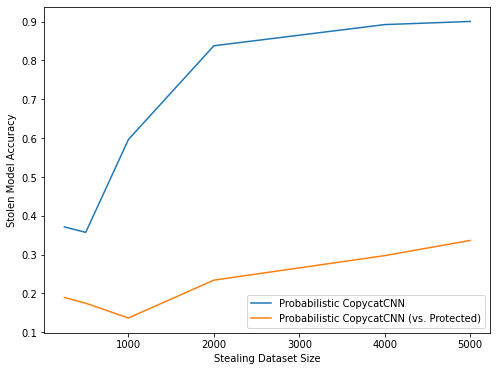

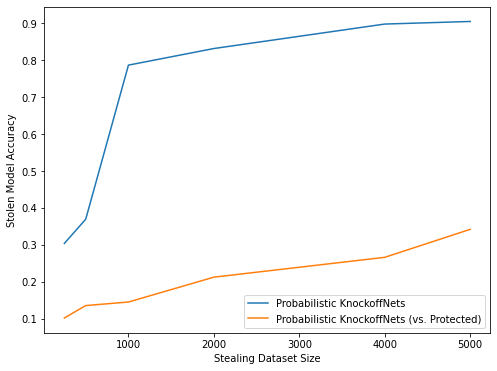

In [14]:
names = ["CopycatCNN", "KnockoffNets"]
for name in names:
    fig, ax = plt.subplots(figsize=(8,6))
    groupby.get_group("Probabilistic " + name).plot(1,2,ax=ax, label="Probabilistic " + name)
    groupby.get_group("Probabilistic " + name + " (vs. Protected)").plot(1,2,ax=ax, label="Probabilistic " + name + " (vs. Protected)")
    ax.set_xlabel("Stealing Dataset Size")
    ax.set_ylabel("Stolen Model Accuracy")
    fig.show()
